# Two-level molasses in 1D

This example covers a two level, 1D optical molasses and compares results to
P. D. Lett, et. al., _J. Opt. Soc. Am. B_ __6__, 2084 (1989).

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pylcp
import lmfit
from scipy.stats import iqr
from pylcp.common import progressBar

## Define the problem

As with every example in `pylcp`, we must first define the Hamiltonian, lasers, and magnetic field.  We will make a two-state system that is addressed only by $\pi$ polarized light.  Note that because we are also using the heuristic equation, we want to make sure that the detuning is not on the Hamiltonian, but on the lasers.

In [121]:
mass = 200
# Make a method to return the lasers:
def return_lasers(delta, s):
    return pylcp.laserBeams([
        {'kvec':np.array([1., 0., 0.]), 'pol':np.array([0., 1., 0.]),
         'pol_coord':'spherical', 'delta':delta, 's':s},
        {'kvec':np.array([-1., 0., 0.]), 'pol':np.array([0., 1., 0.]),
         'pol_coord':'spherical', 'delta':delta, 's':s},
        ], beam_type=pylcp.infinitePlaneWaveBeam)

# Now define a two level Hamiltonian, connected using pi-light.
def return_hamiltonian(delta):
    Hg = np.array([[0.]])
    He = np.array([[-delta]])
    mu_q = np.zeros((3, 1, 1))
    d_q = np.zeros((3, 1, 1))
    d_q[1, 0, 0] = 1.

    return pylcp.hamiltonian(Hg, He, mu_q, mu_q, d_q, mass=mass)

hamiltonian = return_hamiltonian(0.)

magField = lambda R: np.zeros(R.shape)

## Calculate equilibrium forces
### Generate the equilibrium force profile

Do it for all three governing equations at the same step.

In [3]:
delta = -2.
s = 1.5

laserBeams = return_lasers(delta, s)
hamiltonian = return_hamiltonian(0.)
eqns = {}
eqns['obe'] = pylcp.obe(laserBeams, magField, hamiltonian)
eqns['rateeq'] = pylcp.rateeq(laserBeams, magField, hamiltonian)
eqns['heuristiceq'] = pylcp.heuristiceq(laserBeams, magField)

extra_args = {}
extra_args['obe'] = {'progress_bar':True, 'deltat_tmax':2*np.pi*100, 'deltat_v':4,
                     'itermax':1000, 'rel':1e-4, 'abs':1e-6}
extra_args['rateeq'] = {}
extra_args['heuristiceq'] = {}

v = np.arange(-10., 10.1, 0.1)

for key in eqns:
    eqns[key].generate_force_profile(np.zeros((3,) + v.shape),
                                     [v, np.zeros(v.shape), np.zeros(v.shape)],
                                     name='molasses', **extra_args[key])

Completed in 23.55 s.                                               


Plot up the equilibrium force profile, solid for the OBEs, dashed for the rate equations, and dashed-dot for the heuristic equation.

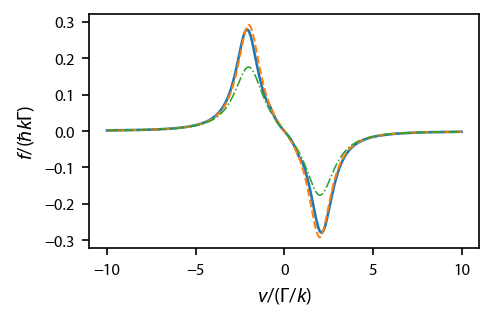

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(3.25, 2.))
lbls = {'obe':'OBE', 'rateeq':'Rate Eq.', 'heuristiceq':'Heuristic Eq.'}
styles = ['-','--','-.']
for ii, key in enumerate(eqns):
    ax.plot(v, eqns[key].profile['molasses'].F[0], styles[ii],
            label=lbls[key], linewidth=1.25-0.25*ii)
    #ax[1].plot(v, eqn.profile['molasses'].Neq)
#ax.legend(fontsize=7)
ax.set_xlabel('$v/(\Gamma/k)$')
ax.set_ylabel('$f/(\hbar k \Gamma)$')
fig.subplots_adjust(bottom=0.2)

For the rate equations and the OBEs, also plot up the equilibrium populations of the two states:

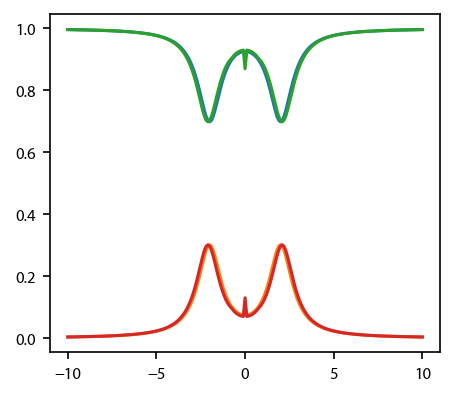

In [5]:
fig, ax = plt.subplots(1, 1)
for key in ['rateeq', 'obe']:
    #ax[0].plot(v, eqn[key].profile['molasses'].F[0])
    ax.plot(v, eqns[key].profile['molasses'].Neq)

### Calculate the damping parameter
We calculate the damping coefficient $\beta$ as a function of $s_0$ and $\delta$, and compare to the Lett expression for the damping.

In [6]:
deltas = np.linspace(-3, 0., 101)
intensities = np.array([0.01, 0.1, 1, 10])

betas = {}
Deltas, Intensities = np.meshgrid(deltas, intensities)

eqns = {'heuristiceq':pylcp.heuristiceq, 'rateeq':pylcp.rateeq, 'obe':pylcp.obe}

extra_args['obe'] = {'deltat':2*np.pi*100, 'itermax':1000, 'rel':1e-4, 'abs':1e-6}
extra_args['rateeq'] = {}
extra_args['heuristiceq'] = {}

for key in eqns:
    it = np.nditer([Deltas, Intensities, None])
    progress = progressBar()
    for (delta, intensity, beta) in it:
        laserBeams = return_lasers(delta, intensity)
        hamiltonian = return_hamiltonian(0.)

        # Next, generate the OBE or rate equations:
        if key is 'heuristiceq':
            eqn = eqns[key](laserBeams, magField)
        else:
            eqn = eqns[key](laserBeams, magField, hamiltonian)

        # Use built in damping_coefficient() method:
        beta[...] = eqn.damping_coeff(axes=[0], **extra_args[key])

        progress.update((it.iterindex+1)/it.itersize)

    # Just update it to be sure.
    progress.update(1.)

    betas[key] = it.operands[2]

Completed in 0.41 s.                                              
Completed in 0.93 s.                                               
Completed in 9:41.                                                  


Plot it up:

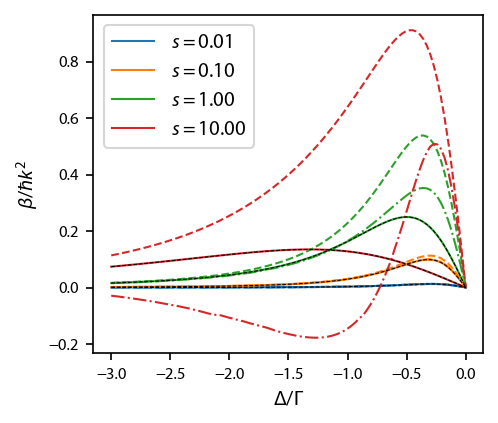

In [7]:
fig, ax = plt.subplots(1, 1)
for ii, key in enumerate(eqns):
    for jj, betas_i in enumerate(betas[key]):
        if ii==0:
            kwargs = {'label':'$s=%.2f$'%intensities[jj]}
        else:
            kwargs = {}
        ax.plot(deltas, betas_i, styles[ii], color='C%d'%jj, linewidth=1., **kwargs)

for ii, intensity in enumerate(intensities):
    ax.plot(deltas, -4*intensity*2*deltas/(1+2*intensity+4*deltas**2)**2, 'k--',
             linewidth=0.5)
    
ax.legend(loc='upper left')
ax.set_xlabel('$\Delta/\Gamma$')
ax.set_ylabel('$\\beta/\hbar k^2$');

## Simulate many atoms to extract temperature
We'll run about $N_A\approx 250$ for about $t_0$ to
generate some histograms and understand what velocities we obtain, etc.

The amount of time we will run for will be scaled against the scattering rate.  So, for a given detuning $\Delta$ and saturation parameter $s$, we will run for
$
    T = T_0 (1+2s+4\Delta^2)/(7 s)
$
where $T_0$ is the time for the simulation at $\Delta=-1$ and $s=1$ (hence the seven in the denominator).

For this step, we will focus on one governing equation.

Completed in 1:46.                                                  


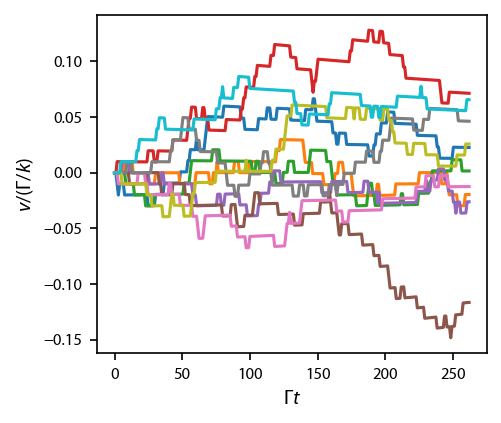

In [122]:
s = 3
delta = -1

T0 = 500 # Time at s=1 and delta=-1
laserBeams = return_lasers(delta, s)
hamiltonian = return_hamiltonian(0.)

eqn = pylcp.heuristiceq(laserBeams, magField, mass=mass)
#eqn = pylcp.rateeq(laserBeams, magField, hamiltonian, include_mag_forces=False)
#eqn = pylcp.obe(laserBeams, magField, hamiltonian)

N_atom = 250
v_final = np.zeros((N_atom,))
#num_of_scatters = np.zeros((N_atom,), dtype='int')
#num_of_steps = np.zeros((N_atom,), dtype='int')

fig, ax = plt.subplots(1, 1)
sols = []
progress = progressBar()
for ii in range(N_atom):
    eqn.set_initial_position_and_velocity(np.array([0., 0., 0.]), np.array([0., 0., 0.]))
    if isinstance(eqn, pylcp.rateeq):
        eqn.set_initial_pop_from_equilibrium()
    elif isinstance(eqn, pylcp.obe):
        eqn.set_initial_rho_from_rateeq()

    eqn.evolve_motion([0., T0*(1+2*s+4*np.abs(delta)**2)/7/s],
                      random_recoil=True,
                      max_scatter_probability=0.25,
                      freeze_axis=[False, True, True])
    progress.update((ii+1.)/N_atom)

    if ii<10:
        ax.plot(eqn.sol.t, eqn.sol.v[0])

    v_final[ii] = eqn.sol.v[0, -1]

    sols.append(eqn.sol)
    #num_of_scatters[ii] = sum(eqn.sol.n_random)
    #num_of_steps[ii] = len(eqn.sol.t)

ax.set_xlabel('$\Gamma t$')
ax.set_ylabel('$v/(\Gamma/k)$');

### Bin the final data and extract temperature

Nominally, this should be more accurate than extracting the temperture through simply measuring the standard deviation.

We use the Freedman–Diaconis rule to determine the bin size, and use bins that are symmetric about zero and span the whole range of $v_{\rm final}$.  We normalize the counts in each bin to $N_A$, which gives us the "experimental" (i.e., through the numerics) probability of landing in the bin between $x-dx/2$ and $x+dx/2$.  We then fit the numerics to the associated expectation from a normal distribution given by $p(x)dx$, where $p(x) = \frac{1}{\sigma\sqrt{2\pi}}e^{-(x-\mu)^2/2\sigma^2}$, $\sigma$ is the standard deviation, and $\mu$ is the mean.  Because the bin size here is fixed and known, we eliminate one additional variable compared to `lmfit`'s built in Gaussian model, namely the amplitude.

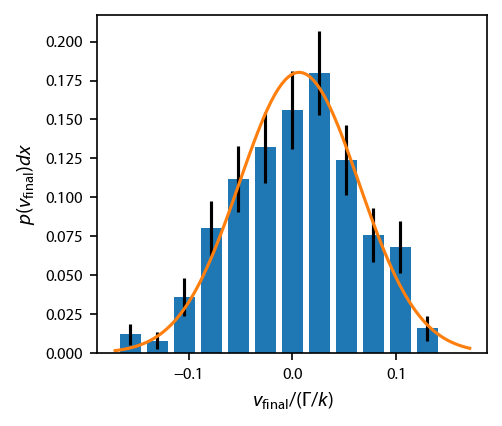

In [123]:
#print(2*np.std(v_final)**2*mass)
def normaldist(x, mu, sigma, dx):
    # Gaussian probability distribution function 
    # probability of landing in a bin of width dx is p(x)dx
    return dx/sigma/np.sqrt(2*np.pi)*np.exp(-(x-mu)**2/2/sigma**2)

dx = 2*iqr(v_final)/N_atom**(1/3)
xb = np.arange(dx/2, 1.1*np.amax(np.abs(v_final)), dx)
xb = np.concatenate((-xb[::-1], xb))

fig, ax = plt.subplots(1, 1)
x = xb[:-1] + np.diff(xb)/2
y = np.histogram(v_final, bins=xb)[0]/N_atom #Probability of an atom landing in this bin.
ax.bar(x, y, width=0.8*dx, yerr=np.sqrt(y/N_atom)) #Poissonian error

ok = (y>0)
weights = 1./(y/N_atom)
model = lmfit.Model(normaldist)
params = model.make_params()
params['dx'].value = dx # bin width, probability of landing in the bin is p(x) dx
params['dx'].vary = False
params['mu'].value = np.mean(v_final)
params['sigma'].value = np.std(v_final)

result = model.fit(y[ok], params, x=x[ok], weights=weights[ok])

x_fit = np.linspace(-1.1*np.amax(np.abs(v_final)), 1.1*np.amax(np.abs(v_final)), 101)

ax.plot(x_fit, result.eval(x=x_fit))
ax.set_ylabel('$p(v_{\\rm final}) dx$')
ax.set_xlabel('$v_{\\rm final}/(\Gamma/k)$');

### Measure the temperature vs. detuning and intensity 

We can compare to the formula in Lett, *et. al.*

In [124]:
deltas = np.array([-3, -2., -1., -0.5, -0.375, -0.25, -0.125])
intensities = np.array([0.3, 1, 3])

t0 = 500 # Evolution time at delta=-1 detuning, s=1
Deltas, Intensities = np.meshgrid(deltas, intensities)

x = {}
y = {}
result = {}

# Make a progress bar:
progress = progressBar()
    
it = np.nditer([Deltas, Intensities, None, None])
for (delta, s, sigma, delta_sigma) in it:
    # First, generate the new laser beams and hamiltonian:
    laserBeams = return_lasers(delta, s)
    hamiltonian = return_hamiltonian(0.)

    # Next, generate the OBE, rate equations or heuristic eqn:
    eqn = pylcp.heuristiceq(laserBeams, magField, mass=mass)
    #eqn = pylcp.rateeq(laserBeams, magField, hamiltonian, include_mag_forces=False)

    # Now, evolve however many times:
    # progress = progressBar()
    for ii in range(N_atom):
        eqn.set_initial_position_and_velocity(np.array([0., 0., 0.]),
                                              np.array([0., 0., 0.]))
        if isinstance(eqn, pylcp.rateeq):
            eqn.set_initial_pop_from_equilibrium()
        elif isinstance(eqn, pylcp.obe):
            eqn.set_initial_rho_from_rateeq()

        eqn.evolve_motion([0., t0*(1+2*s+4*np.abs(delta)**2)/7/s],
                          random_recoil=True,
                          max_scatter_probability=0.25,
                          freeze_axis=[False, True, True])

        v_final[ii] = eqn.sol.v[0, -1]
        
        # progress.update((ii+1.)/N_atom)
        
    # Now bin and fit, just as above:
    dx = 2*iqr(v_final)/N_atom**(1/3)
    xb = np.arange(dx/2, 1.1*np.amax(np.abs(v_final)), dx)
    xb = np.concatenate((-xb[::-1], xb))

    key = (float(delta), float(s))
    x[key] = xb[:-1] + np.diff(xb)/2
    y[key] = np.histogram(v_final, bins=xb)[0]/N_atom

    ok = (y[key]>0)
    weights = 1./(y[key]/N_atom)
    model = lmfit.Model(normaldist)
    params = model.make_params()
    params['dx'].value = dx
    params['dx'].vary = False
    params['mu'].value = np.mean(v_final)
    params['sigma'].value = np.std(v_final)

    result[key] = model.fit(y[key][ok], params, x=x[key][ok], weights=weights[ok])

    sigma[...] = result[key].best_values['sigma']
    delta_sigma[...] = result[key].params['sigma'].stderr

    progress.update((it.iterindex+1)/it.itersize)

# Finish updating the progress bar just in case:
progress.update(1.)

Completed in 28:22.                                               


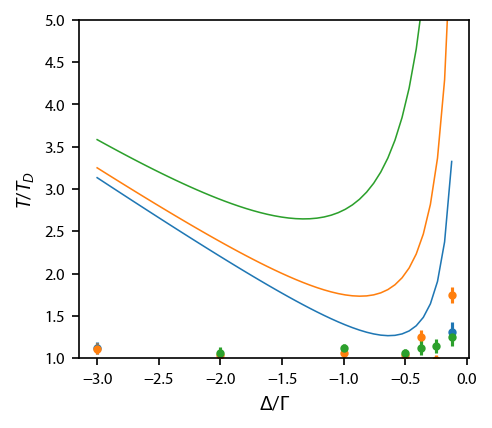

In [125]:
def lett_function(s, delta):
    return 0.5*(1+2*s+4*delta **2)/2/np.abs(delta)

deltas_thr = np.linspace(-3, -0.125, 51)
fig, ax = plt.subplots(1, 1)
for ii, (s, sigmas, err) in enumerate(zip(intensities, it.operands[2], it.operands[3])):
    plt.errorbar(deltas, 2*sigmas**2*mass, 4*sigmas*err*mass, fmt='.', color='C%d'%ii)
    plt.plot(deltas_thr, lett_function(s, deltas_thr), linewidth=0.75, color='C%d'%ii)
ax.set_xlabel('$\Delta/\Gamma$')
ax.set_ylabel('$T/T_D$')
ax.set_ylim((1, 5));